# Coffea-Casa Processor-Based Workflow Test

This notebook demonstrates the UnifiedProcessor workflow with coffea.processor.Runner on Coffea-Casa, including skimming, analysis, histogramming, and statistics steps.

## Workflow Overview

1. Setup Python path for intccms package
2. Install dependencies and register modules for cloud pickle
3. Acquire Dask client from Coffea-Casa environment
4. Configure analysis parameters
5. Run metadata extraction
6. Initialize UnifiedProcessor
7. Run processor with coffea.processor.Runner
8. Save histograms
9. Run statistical analysis (if enabled)

In [1]:
# Setup Python path to include intccms package
import sys
import time
from pathlib import Path

# Add src directory to Python path
repo_root = Path.cwd()
src_dir = repo_root / "src"
examples_dir = repo_root
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))
if str(examples_dir) not in sys.path:
    sys.path.insert(0, str(examples_dir))
print(f"✅ Added {src_dir} to Python path")
print(f"✅ Added {examples_dir} to Python path")

✅ Added /home/cms-jovyan/intccms-agc-demo-10/src to Python path
✅ Added /home/cms-jovyan/intccms-agc-demo-10 to Python path


In [2]:
COFFEA_VERSION = "2025.10.3.dev17+g2cde65fb6" # 2025.10.2
COFFEA_PIP = "coffea==2025.11.0" #"git+https://github.com/scikit-hep/coffea@master"
try:
    import omegaconf
except ImportError:
    print("⚠️ omegaconf not found, installing...")
    ! pip install omegaconf

try:
    import coffea
    print("Coffea version: ", coffea.__version__)
    assert coffea.__version__ == "2025.10.3.dev9+g41c84f7a9"
except (ImportError, AssertionError):
    print("⚠️ coffea not found or incorrect version, installing...")
    ! pip install $COFFEA_PIP
print("✅ All dependencies are installed.")

Coffea version:  2025.11.0
⚠️ coffea not found or incorrect version, installing...
✅ All dependencies are installed.


In [3]:
# Imports and cloudpickle registration
import copy
import os

os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""

from dask.distributed import Client, PipInstall
from coffea.processor import DaskExecutor, IterativeExecutor
from coffea.nanoevents import NanoAODSchema

import cloudpickle
import intccms
import example_cms

# Register modules for cloud pickle
cloudpickle.register_pickle_by_value(intccms)
cloudpickle.register_pickle_by_value(example_cms)

from example_cms.configs.configuration import config as original_config
from intccms.schema import Config, load_config_with_restricted_cli
from intccms.utils.output import OutputDirectoryManager
from intccms.metadata_extractor import DatasetMetadataManager
from intccms.datasets import DatasetManager
from intccms.analysis import run_processor_workflow

## Acquire Dask Client

Coffea-Casa provides a shared scheduler. Connect to it and register dependencies.

In [4]:
from dask.distributed import WorkerPlugin

class RedirectStderrToStdout(WorkerPlugin):
    def setup(self, worker):
        # crude but effective: route stderr to stdout
        sys.stderr = sys.stdout



def acquire_client(af="condor"):
    """Acquire Dask client from Coffea-Casa environment."""
    dependencies = [COFFEA_PIP] #["coffea==2025.10.2"]

    if af == "condor":
        client = Client("tls://localhost:8786")
        client.register_plugin(PipInstall(packages=dependencies))
        cluster = None
        return client, cluster
    
    elif af == "gateway":
        def set_env(dask_worker):
            config_path = str(Path(dask_worker.local_directory) / 'access_token')
            os.environ["BEARER_TOKEN_FILE"] = config_path
            os.chmod(config_path, 0o600)
            os.chmod("/etc/grid-security/certificates", 0o755)

        num_workers = 350   #number of workers desired
        from dask_gateway import Gateway
        gateway = Gateway()
        clusters = gateway.list_clusters()
        cluster = gateway.connect(clusters[0].name)
        client = cluster.get_client()
        cluster.scale(num_workers)
        client.wait_for_workers(num_workers)
        client.upload_file("/etc/cmsaf-secrets-chown/access_token")     
        client.register_worker_callbacks(setup=set_env)
        client.register_plugin(PipInstall(packages=dependencies))
        # Register from client *before* workers start
        client.register_worker_plugin(RedirectStderrToStdout(), name="redirect-stderr")
        
        return client, cluster    

## Configuration Setup

Configure analysis parameters including which processes to run and output settings.

In [5]:
# Configuration setup
config = copy.deepcopy(original_config)

# Limit files for testing
config["datasets"]["max_files"] = None

# Use local output directory
config["general"]["output_dir"] = "example_cms/outputs/"

# Configuration flags
config["general"]["read_from_cache"] = False
config["general"]["run_metadata_generation"] = False
config["general"]["run_processor"] = True  # Set to False to skip processor and load saved histograms
config["general"]["save_skimmed_output"] = False  # Set to True to save filtered events to disk
config["general"]["run_analysis"] = True
config["general"]["run_histogramming"] = True
config["general"]["run_systematics"] = True
config["general"]["run_statistics"] = True

# Test only signal dataset
#config["general"]["processes"] = ["data"]

cli_args = []
full_config = load_config_with_restricted_cli(config, cli_args)
validated_config = Config(**full_config)

print(f"✅ Configuration loaded with max_files={validated_config.datasets.max_files}")
print(f"   - run_processor: {validated_config.general.run_processor}")
print(f"   - save_skimmed_output: {validated_config.general.save_skimmed_output}")
print(f"   - run_analysis: {validated_config.general.run_analysis}")
print(f"   - run_histogramming: {validated_config.general.run_histogramming}")
print(f"   - run_systematics: {validated_config.general.run_systematics}")
print(f"   - run_statistics: {validated_config.general.run_statistics}")

✅ Configuration loaded with max_files=None
   - run_processor: True
   - save_skimmed_output: False
   - run_analysis: True
   - run_histogramming: True
   - run_systematics: True
   - run_statistics: True


## Run Complete Workflow

Execute the full processor workflow with proper cleanup in a try/finally block.

/tmp/ipykernel_1165/941773372.py:39: DeprecationWarning: `Client.register_worker_plugin` has been deprecated; please use `Client.register_plugin` instead
  client.register_worker_plugin(RedirectStderrToStdout(), name="redirect-stderr")


✅ Connected to Dask scheduler
📊 Dashboard: /services/dask-gateway/clusters/cmsaf-dev.e8601ecae64f46e8a5b0eb023491aeb7/status


12:34:52 INFO     Output directory manager initialized with root:                                ]8;id=92411;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/directories.py\directories.py]8;;\:]8;id=59888;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/directories.py#169\169]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs                                         

✅ Output directory: /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs

📋 Extracting metadata...


         INFO     Initialized dataset manager with 10 datasets                                        ]8;id=701886;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/datasets/manager.py\manager.py]8;;\:]8;id=141919;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/datasets/manager.py#34\34]8;;\

         INFO     Initialized DatasetMetadataManager with output dir:                                ]8;id=774837;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=58545;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#131\131]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/metadata                                

         INFO     Loading existing metadata from:                                                    ]8;id=356727;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=490042;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#221\221]8;;\
                  {                                                                                                
                      'fileset_path':                                                                              
                  PosixPath('/home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/metadata/files               
                  et.json'),                                                                                       
                      'workitems_path':                                                                            
                  PosixPath('/home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/metadata/worki               
                  tems.json'),                                                                                     
                      'nanoaods_summary_path':                                                                     
                  PosixPath('/home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/metadata/nanoa               
                  ods.json')                                                                                       
                  }                                                                                                

         INFO     Loaded 10 Dataset objects from fileset                                             ]8;id=91789;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=184967;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#326\326]8;;\

         INFO     Loaded 39603 WorkItems                                                             ]8;id=61565;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=619236;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#333\333]8;;\

         INFO     Loaded event count summary                                                         ]8;id=348072;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=862390;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#339\339]8;;\

         INFO     All metadata successfully loaded from disk.                                        ]8;id=260818;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=384202;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#229\229]8;;\

         INFO     Built metadata lookup for 125 fileset keys                                         ]8;id=293482;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=567494;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/metadata_extractor/manager.py#427\427]8;;\

✅ Generated 39603 workitems

🔍 Workitem Details (first 5):
  0: dataset='signal_0__nominal' process='signal'
  1: dataset='signal_0__nominal' process='signal'
  2: dataset='signal_1__nominal' process='signal'
  3: dataset='signal_1__nominal' process='signal'
  4: dataset='signal_1__nominal' process='signal'
  ... and 39598 more

🚀 Running processor workflow...


         INFO     Running processor over data...                                                      ]8;id=5179;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=338229;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#125\125]8;;\

         INFO     Initialized UnifiedProcessor: save_skimmed_output=False, analysis=True,          ]8;id=623621;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=790198;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py#194\194]8;;\
                  histogramming=True, systematics=True                                                             

         INFO     Started worker tracking on scheduler                                                ]8;id=23105;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=919179;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#216\216]8;;\

         INFO     Processing 39603 work items with chunksize=200000                                   ]8;id=54372;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=503721;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#247\247]8;;\

/usr/local/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 14.96 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Output()

12:39:10 INFO     Postprocessing complete: 6827277103 total events                                 ]8;id=664214;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=130707;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py#382\382]8;;\

         INFO     Histograms written to pickle:                                                    ]8;id=884669;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=795288;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/histograms.py#45\45]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/histograms/processor_hi                 
                  stograms.pkl                                                                                     

         INFO     Saved processor histograms (pickle) to                                           ]8;id=300973;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=11542;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py#394\394]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/histograms/processor_hi                 
                  stograms.pkl                                                                                     

         INFO     Filtered 8 invalid systematic variations from data samples                      ]8;id=420509;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=164769;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/histograms.py#188\188]8;;\

         INFO     Histograms written to ROOT file:                                                ]8;id=66855;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=631224;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/utils/output/histograms.py#137\137]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/histograms/histograms.                  
                  root                                                                                             

         INFO     Saved processor histograms (ROOT) to                                             ]8;id=56834;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=973483;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py#402\402]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/histograms/histograms.r                 
                  oot                                                                                              

         INFO     Running statistical analysis...                                                  ]8;id=161655;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=407343;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py#409\409]8;;\

         INFO     Running statistical analysis and visualization                                     ]8;id=87914;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=526041;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#362\362]8;;\

         INFO     opening config file example_cms/outputs/cabinetry/cabinetry_config.yaml       ]8;id=712524;file:///usr/local/lib/python3.12/site-packages/cabinetry/configuration.py\configuration.py]8;;\:]8;id=234929;file:///usr/local/lib/python3.12/site-packages/cabinetry/configuration.py#26\26]8;;\

         INFO     building workspace                                                               ]8;id=575833;file:///usr/local/lib/python3.12/site-packages/cabinetry/workspace.py\workspace.py]8;;\:]8;id=755790;file:///usr/local/lib/python3.12/site-packages/cabinetry/workspace.py#430\430]8;;\

         INFO     Validating spec against schema: workspace.json                                   ]8;id=116166;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py\workspace.py]8;;\:]8;id=991856;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py#312\312]8;;\

         INFO     Validating spec against schema: workspace.json                                   ]8;id=612146;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py\workspace.py]8;;\:]8;id=282428;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py#312\312]8;;\

         INFO     Validating spec against schema: model.json                                             ]8;id=2515;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=73530;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#768\768]8;;\

         INFO     adding modifier MU_ID_SF (1 new nuisance parameters)                                   ]8;id=479347;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=894808;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier PU_weight (1 new nuisance parameters)                                  ]8;id=996858;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=494872;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier zprime_norm (1 new nuisance parameters)                                ]8;id=605185;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=687147;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier ttbar_norm (1 new nuisance parameters)                                 ]8;id=728441;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=458277;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier staterror_CMS_WORKSHOP (10 new nuisance parameters)                    ]8;id=609553;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=478401;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     performing maximum likelihood fit                                                 ]8;id=839760;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=639968;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#478\478]8;;\

12:39:11 INFO     Migrad status:                                                                    ]8;id=381586;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=794475;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#108\108]8;;\
                  ┌─────────────────────────────────────────────────────────────────────────┐                      
                  │                                Migrad                                   │                      
                  ├──────────────────────────────────┬──────────────────────────────────────┤                      
                  │ FCN = 30.54                      │             Nfcn = 2261              │                      
                  │ EDM = 7.25e-05 (Goal: 0.0002)    │                                      │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │          Valid Minimum           │   Below EDM threshold (goal x 10)    │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │     SOME parameters at limit     │           Below call limit           │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │             Hesse ok             │         Covariance accurate          │                      
                  └──────────────────────────────────┴──────────────────────────────────────┘                      

         INFO     fit results (with symmetric uncertainties):                                        ]8;id=703524;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=65880;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#35\35]8;;\

         INFO     MU_ID_SF                  =  0.0432 +/- 0.0787                                     ]8;id=122564;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=500366;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     PU_weight                 = -0.0007 +/- 0.0005                                     ]8;id=368015;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=690630;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     zprime_norm               =  9.9965 +/- 5.4470                                     ]8;id=216089;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=168654;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     ttbar_norm                =  1.9242 +/- 0.3578                                     ]8;id=964329;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=209870;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[0] =  1.0009 +/- 0.0083                                     ]8;id=558452;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=408427;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[1] =  0.9974 +/- 0.0063                                     ]8;id=515388;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=479244;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[2] =  1.0044 +/- 0.0059                                     ]8;id=241194;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=830784;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[3] =  1.0000 +/- 0.0040                                     ]8;id=216496;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=558671;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[4] =  0.9989 +/- 0.0042                                     ]8;id=737444;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=768873;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[5] =  0.9995 +/- 0.0059                                     ]8;id=336748;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=165200;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[6] =  1.0008 +/- 0.0088                                     ]8;id=48587;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=372706;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[7] =  1.0021 +/- 0.0130                                     ]8;id=114544;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=679512;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[8] =  0.9971 +/- 0.0193                                     ]8;id=22007;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=819984;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[9] =  0.9916 +/- 0.0288                                     ]8;id=629127;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=350900;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     Creating pre-fit data/MC plots                                                     ]8;id=149162;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=90015;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#375\375]8;;\

         INFO     saving figure as                                                                      ]8;id=217030;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=487600;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/CMS_WORKSHOP_pref            
                  it.pdf                                                                                           

         INFO     Creating post-fit data/MC plots                                                    ]8;id=211866;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=240071;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#384\384]8;;\

12:39:12 INFO     saving figure as                                                                      ]8;id=574516;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=23290;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/CMS_WORKSHOP_post            
                  fit.pdf                                                                                          

         INFO     Creating pull plots                                                                ]8;id=923955;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=387721;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#393\393]8;;\

         INFO     saving figure as                                                                      ]8;id=870094;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=245768;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/pulls.pdf                    

         INFO     ✅ Statistical analysis complete. Plots saved to                                   ]8;id=420783;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=685807;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#400\400]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics                              

         INFO     Statistical analysis complete. Results saved to                                  ]8;id=999111;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=973673;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/processor.py#427\427]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics                              

12:39:15 INFO     Processor complete: 6,827,277,103 events processed, 297,458,382 events after skim   ]8;id=505130;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=391976;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#263\263]8;;\

12:39:16 INFO     Saved worker timeline to                                                            ]8;id=168673;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=554988;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#278\278]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/benchmarks/20251129-123452              

12:39:17 INFO     Saved metrics measurement to                                                        ]8;id=752102;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=776147;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#296\296]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/benchmarks/20251129-123452              

         INFO     📊 Dask performance report:                                                         ]8;id=759100;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=513711;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#300\300]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/benchmarks/20251129-123452              
                  /dask_performance.html                                                                           

         INFO     📈 Metrics: 19.10 Gbps, 25957.9 kHz                                                 ]8;id=634047;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=356370;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/runner.py#303\303]8;;\

✅ Processor workflow complete!

📊 Results:
📊 Total events processed: 6,827,277,103
✂️  Events after skim: 297,458,382

✅ Complete processor workflow finished!

🧹 Cleaning up...
✅ Done!


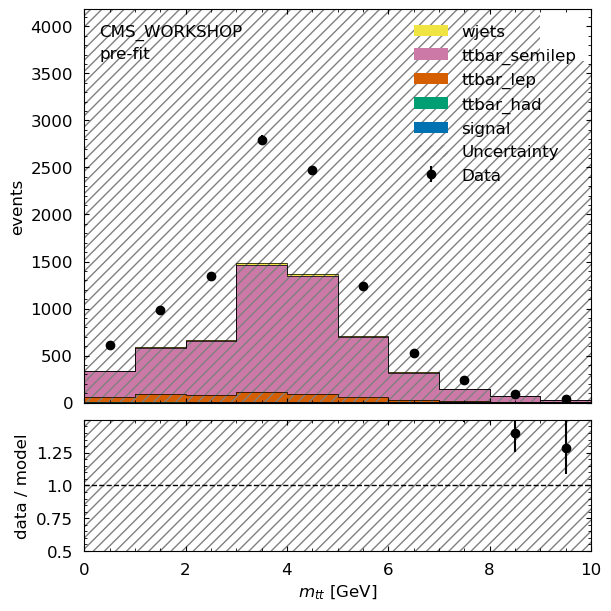

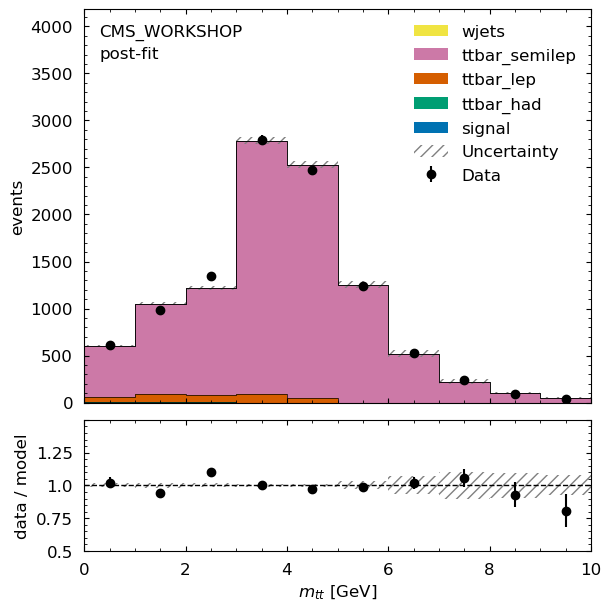

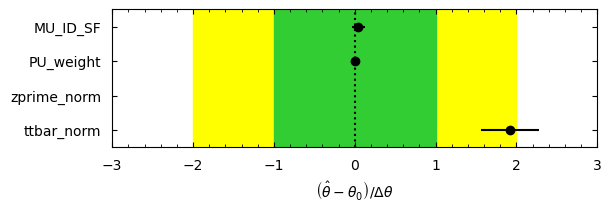

In [6]:
try:
    client, cluster = acquire_client(af="gateway")
    print(f"✅ Connected to Dask scheduler")
    print(f"📊 Dashboard: {client.dashboard_link}")
    # Output Manager Setup
    output_manager = OutputDirectoryManager(
        root_output_dir=validated_config.general.output_dir,
        cache_dir=validated_config.general.cache_dir,
        metadata_dir=validated_config.general.metadata_dir,
        skimmed_dir=validated_config.general.skimmed_dir
    )
    print(f"✅ Output directory: {output_manager.root_output_dir}")

    # Step 1: Metadata Extraction
    print("\n📋 Extracting metadata...")
    dataset_manager = DatasetManager(validated_config.datasets)
    metadata_generator = DatasetMetadataManager(
        dataset_manager=dataset_manager,
        output_manager=output_manager,
        executor=DaskExecutor(client=client),
        config=validated_config,
    )
    metadata_generator.run(
        generate_metadata=validated_config.general.run_metadata_generation,
        processes_filter=validated_config.general.processes if hasattr(validated_config.general, 'processes') else None
    )

    metadata_lookup = metadata_generator.build_metadata_lookup()
    workitems = metadata_generator.workitems


    print(f"✅ Generated {len(workitems)} workitems")

    # Show first few workitems
    print("\n🔍 Workitem Details (first 5):")
    for i, wi in enumerate(workitems[:5]):
        print(f"  {i}: dataset='{wi.dataset}' process='{wi.usermeta.get('process', 'N/A')}'")
    if len(workitems) > 5:
        print(f"  ... and {len(workitems) - 5} more")

    # Step 2: Run Processor Workflow (or load saved histograms)
    print("\n🚀 Running processor workflow...")
    t0 = time.perf_counter()
    output, report, metrics = run_processor_workflow(
        config=validated_config,
        output_manager=output_manager,
        metadata_lookup=metadata_lookup,
        workitems=workitems,
        executor=DaskExecutor(client=client, treereduction=8, retries=0),
        schema=NanoAODSchema,
    )
    t1 = time.perf_counter()
    print("✅ Processor workflow complete!")

    # Step 3: Display Results
    print("\n" + "=" * 60)
    print("📊 Results:")
    print("=" * 60)

    if validated_config.general.run_processor:
        print(f"📊 Total events processed: {output.get('processed_events', 0):,}")
        if 'skimmed_events' in output:
            print(f"✂️  Events after skim: {output.get('skimmed_events', 0):,}")

    # Summary
    print("\n" + "=" * 60)
    print("✅ Complete processor workflow finished!")
    print("=" * 60)

finally:
    # Cleanup
    print("\n🧹 Cleaning up...")
    client.close()
    print("✅ Done!")

In [7]:
report

{'bytesread': 627999099625,
 'columns': [Accessed(branch='Muon_pt', buffer_key='f661ec80-ee63-11eb-b0b8-a57f010abeef/%2FEvents%3B1/781880-977350/data/Muon_pt%2C%21load%2C%21content'),
  Accessed(branch='genWeight', buffer_key='41ad7f94-f0d8-11eb-8856-17bee183beef/%2FEvents%3B1/942860-1131432/data/genWeight%2C%21load'),
  Accessed(branch='Jet_mass', buffer_key='3406c91e-487a-11ec-9c80-90cce183beef/%2FEvents%3B1/1188000-1386000/data/Jet_mass%2C%21load%2C%21content'),
  Accessed(branch='FatJet_pt', buffer_key='31943e28-e51c-11ee-b55a-84e65d9fbeef/%2FEvents%3B1/0-86792/data/FatJet_pt%2C%21load%2C%21content'),
  Accessed(branch='Jet_btagDeepB', buffer_key='7b8f09c2-2241-11ec-94e9-addca8c0beef/%2FEvents%3B1/853336-1066670/data/Jet_btagDeepB%2C%21load%2C%21content'),
  Accessed(branch='nFatJet', buffer_key='98c35a40-c0b2-11ee-97ee-131fa8c0beef/%2FEvents%3B1/0-18770/offsets/nFatJet%2C%21load%2C%21counts2offsets%2C%21skip%2C%21offsets'),
  Accessed(branch='FatJet_mass', buffer_key='9bf26e6e-f21

In [8]:
# event size
# number of files per dataset
# file sizes
# number of events per file
# size of branches (per branch, per % branches)
# processor time (split IO vs process)

In [9]:
print(f"data read: {report["bytesread"] / 1000**3:.2f} GB in {report["chunks"]} chunks")

print(f"core-average event rate using \'processtime\': {report["entries"] / 1000 / report["processtime"]:.2f} kHz")
print(f"core-average data rate using \'processtime\': {report["bytesread"] / 1000**3 * 8 / report["processtime"]:.2f} Gbps")

print(f"average event rate using walltime: {report["entries"] / 1000 / (t1 - t0):.2f} kHz")
print(f"average data rate using walltime: {report["bytesread"] / 1000**3 * 8 / (t1 - t0):.2f} Gbps")

print(f"Number of branches read: {len(report["columns"])}")

data read: 628.00 GB in 39603 chunks
core-average event rate using 'processtime': 60.40 kHz
core-average data rate using 'processtime': 0.04 Gbps
average event rate using walltime: 25822.60 kHz
average data rate using walltime: 19.00 Gbps
Number of branches read: 835431


In [10]:
# Import Rich for beautiful table display
from rich.console import Console

console = Console()

print("\n" + "=" * 60)
print("📊 Processing Metrics")
print("=" * 60)


📊 Processing Metrics


In [11]:
# Display metrics if collection was enabled
if metrics:
    from intccms.metrics import (
        format_throughput_table,
        format_event_processing_table,
        format_resources_table,
        format_timing_table,
    )
    
    print("\n📈 Throughput Metrics")
    console.print(format_throughput_table(metrics))
    
    print("\n⚡ Event Processing Metrics")
    console.print(format_event_processing_table(metrics))
    
    print("\n🖥️  Resource Utilization")
    console.print(format_resources_table(metrics))
    
    print("\n⏱️  Timing Breakdown")
    console.print(format_timing_table(metrics))
else:
    print("⚠️  Metrics collection was disabled (set config.general.metrics.enable=True)")


📈 Throughput Metrics


                        Throughput Metrics                        
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric            ┃ Value                                      ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Data Rate         │ 19.10 Gbps (2387.7 MB/s)                   │
│ Compression Ratio │ 2.50x                                      │
│ Total Data Read   │ 584.87 GB compressed, 1.43 TB uncompressed │
└───────────────────┴────────────────────────────────────────────┘


⚡ Event Processing Metrics


            Event Processing Metrics            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃ Value           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Total Events               │ 6,827,277,103   │
│ Event Rate (Wall Clock)    │ 25957.9 kHz     │
│ Event Rate (Aggregated)    │ 60.4 kHz        │
│ Event Rate (Core-Averaged) │ 37164.2 Hz/core │
│ Efficiency Ratio           │ 42974.2%        │
└────────────────────────────┴─────────────────┘


🖥️  Resource Utilization


        Resource Utilization        
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                  ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Workers (Time-Averaged) │ 349.2  │
│ Peak Workers            │ 351    │
│ Total Cores             │ 698    │
│ Core Efficiency         │ 61.5%  │
│ Speedup Factor          │ 429.7x │
└─────────────────────────┴────────┘


⏱️  Timing Breakdown


          Timing Breakdown          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Metric             ┃ Value       ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Wall Time          │ 4m 23s      │
│ Total CPU Time     │ 31h 23m 47s │
│ Number of Chunks   │ 39,603      │
│ Avg CPU Time/Chunk │ 2.9s        │
└────────────────────┴─────────────┘


📊 Running statistical analysis...
✅ Using cabinetry config: example_cms/outputs/cabinetry/cabinetry_config.yaml


12:39:18 INFO     Running statistical analysis and visualization                                     ]8;id=128823;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=985222;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#362\362]8;;\

         INFO     opening config file example_cms/outputs/cabinetry/cabinetry_config.yaml       ]8;id=950847;file:///usr/local/lib/python3.12/site-packages/cabinetry/configuration.py\configuration.py]8;;\:]8;id=321619;file:///usr/local/lib/python3.12/site-packages/cabinetry/configuration.py#26\26]8;;\

         INFO     building workspace                                                               ]8;id=418052;file:///usr/local/lib/python3.12/site-packages/cabinetry/workspace.py\workspace.py]8;;\:]8;id=324648;file:///usr/local/lib/python3.12/site-packages/cabinetry/workspace.py#430\430]8;;\

         INFO     Validating spec against schema: workspace.json                                   ]8;id=273985;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py\workspace.py]8;;\:]8;id=596887;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py#312\312]8;;\

         INFO     Validating spec against schema: workspace.json                                   ]8;id=826721;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py\workspace.py]8;;\:]8;id=976043;file:///usr/local/lib/python3.12/site-packages/pyhf/workspace.py#312\312]8;;\

         INFO     Validating spec against schema: model.json                                             ]8;id=479110;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=60618;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#768\768]8;;\

         INFO     adding modifier MU_ID_SF (1 new nuisance parameters)                                   ]8;id=484611;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=667668;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier PU_weight (1 new nuisance parameters)                                  ]8;id=899642;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=731749;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier zprime_norm (1 new nuisance parameters)                                ]8;id=227126;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=374341;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier ttbar_norm (1 new nuisance parameters)                                 ]8;id=280005;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=588580;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     adding modifier staterror_CMS_WORKSHOP (10 new nuisance parameters)                    ]8;id=638260;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py\pdf.py]8;;\:]8;id=552043;file:///usr/local/lib/python3.12/site-packages/pyhf/pdf.py#478\478]8;;\

         INFO     performing maximum likelihood fit                                                 ]8;id=847358;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=763387;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#478\478]8;;\

         INFO     Migrad status:                                                                    ]8;id=749718;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=743891;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#108\108]8;;\
                  ┌─────────────────────────────────────────────────────────────────────────┐                      
                  │                                Migrad                                   │                      
                  ├──────────────────────────────────┬──────────────────────────────────────┤                      
                  │ FCN = 30.54                      │             Nfcn = 2261              │                      
                  │ EDM = 7.25e-05 (Goal: 0.0002)    │                                      │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │          Valid Minimum           │   Below EDM threshold (goal x 10)    │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │     SOME parameters at limit     │           Below call limit           │                      
                  ├──────────────────────────────────┼──────────────────────────────────────┤                      
                  │             Hesse ok             │         Covariance accurate          │                      
                  └──────────────────────────────────┴──────────────────────────────────────┘                      

         INFO     fit results (with symmetric uncertainties):                                        ]8;id=246065;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=596109;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#35\35]8;;\

         INFO     MU_ID_SF                  =  0.0432 +/- 0.0787                                     ]8;id=770753;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=230318;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     PU_weight                 = -0.0007 +/- 0.0005                                     ]8;id=748407;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=519733;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     zprime_norm               =  9.9965 +/- 5.4470                                     ]8;id=336473;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=885530;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     ttbar_norm                =  1.9242 +/- 0.3578                                     ]8;id=735388;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=323095;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[0] =  1.0009 +/- 0.0083                                     ]8;id=206540;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=619853;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[1] =  0.9974 +/- 0.0063                                     ]8;id=663861;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=189465;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[2] =  1.0044 +/- 0.0059                                     ]8;id=315833;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=6606;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[3] =  1.0000 +/- 0.0040                                     ]8;id=579495;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=806280;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[4] =  0.9989 +/- 0.0042                                     ]8;id=579551;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=192125;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[5] =  0.9995 +/- 0.0059                                     ]8;id=309347;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=855620;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[6] =  1.0008 +/- 0.0088                                     ]8;id=172814;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=825659;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[7] =  1.0021 +/- 0.0130                                     ]8;id=242295;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=877636;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[8] =  0.9971 +/- 0.0193                                     ]8;id=733818;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=295142;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     staterror_CMS_WORKSHOP[9] =  0.9916 +/- 0.0288                                     ]8;id=758040;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py\__init__.py]8;;\:]8;id=430839;file:///usr/local/lib/python3.12/site-packages/cabinetry/fit/__init__.py#38\38]8;;\

         INFO     Creating pre-fit data/MC plots                                                     ]8;id=204754;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=161496;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#375\375]8;;\

         INFO     saving figure as                                                                      ]8;id=235669;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=332147;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/CMS_WORKSHOP_pref            
                  it.pdf                                                                                           

         INFO     Creating post-fit data/MC plots                                                    ]8;id=50667;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=487974;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#384\384]8;;\

12:39:19 INFO     saving figure as                                                                      ]8;id=660880;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=85080;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/CMS_WORKSHOP_post            
                  fit.pdf                                                                                          

         INFO     Creating pull plots                                                                ]8;id=535219;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=509263;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#393\393]8;;\

         INFO     saving figure as                                                                      ]8;id=619966;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py\utils.py]8;;\:]8;id=15254;file:///usr/local/lib/python3.12/site-packages/cabinetry/visualize/utils.py#27\27]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics/pulls.pdf                    

         INFO     ✅ Statistical analysis complete. Plots saved to                                   ]8;id=527286;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py\nondiff.py]8;;\:]8;id=673848;file:///home/cms-jovyan/intccms-agc-demo-10/src/intccms/analysis/nondiff.py#400\400]8;;\
                  /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics                              

✅ Statistical analysis complete!
📊 Plots saved to: /home/cms-jovyan/intccms-agc-demo-10/example_cms/outputs/statistics


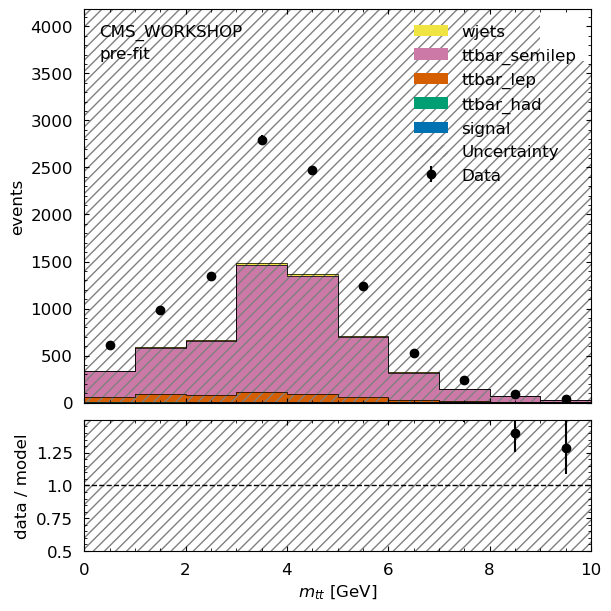

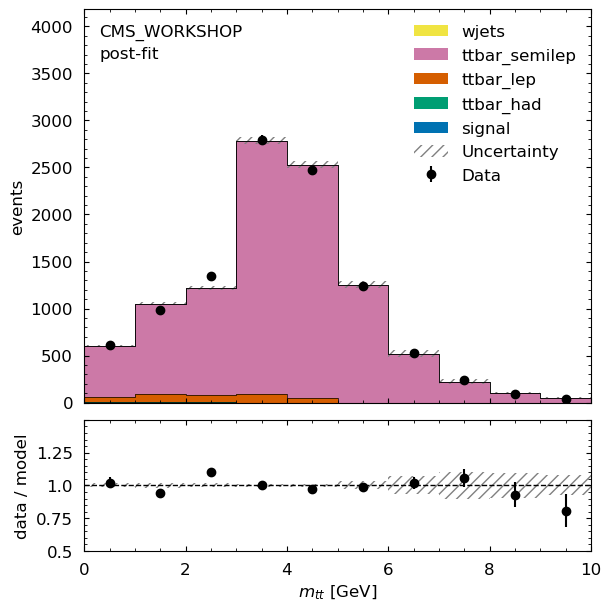

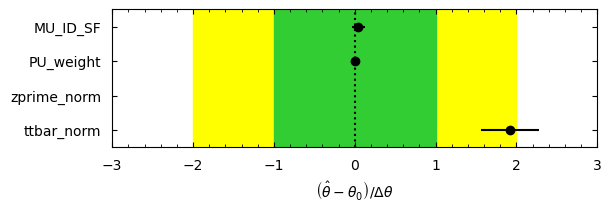

In [12]:
    # Step 4: Run Statistical Analysis
    if validated_config.general.run_statistics and output and "histograms" in output:
        print("\n📊 Running statistical analysis...")

        # Create analysis instance for statistics
        from intccms.analysis.nondiff import NonDiffAnalysis

        analysis = NonDiffAnalysis(validated_config, output_manager)
        # Set histograms from processor output
        analysis.nD_hists_per_region = output["histograms"]

        # Check if cabinetry config exists
        if hasattr(validated_config, 'statistics') and hasattr(validated_config.statistics, 'cabinetry_config'):
            cabinetry_config_path = validated_config.statistics.cabinetry_config

            # Check if file exists
            if Path(cabinetry_config_path).exists():
                print(f"✅ Using cabinetry config: {cabinetry_config_path}")
                analysis.run_statistics(cabinetry_config_path)
                print(f"✅ Statistical analysis complete!")
                print(f"📊 Plots saved to: {output_manager.statistics_dir}")
            else:
                print(f"⚠️  Cabinetry config not found: {cabinetry_config_path}")
                print(f"   Skipping statistics step")
        else:
            print(f"⚠️  No cabinetry_config specified in configuration")
            print(f"   Skipping statistics step")
    else:
        print("\n⚠️  Statistics step skipped (disabled or no histograms)")
